In [1]:
import math
from collections import defaultdict
from dataclasses import dataclass
from heapq import heappop, heappush
from typing import Callable, Iterable, List, Optional, Tuple, Type, Union

from colorama import Fore
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

%matplotlib inline

## Grid map representation

In [2]:
class Map:

    def __init__(self, cells: npt.NDArray, name: Optional[str] = None):
        self._name = name
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        return not self._cells[i, j]

    def get_neighbours(self, i: int, j: int) -> List[Tuple[int, int]]:
        neighbours = []
        delta_cardinal = ((0, 1), (1, 0), (0, -1), (-1, 0))
        for (dx, dy) in delta_cardinal:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj):
                neighbours.append((ni, nj))
        # 8-connecting grid
        delta_diagonal = ((1, 1), (1, -1), (-1, 1), (-1, -1))
        for (dx, dy) in delta_diagonal:
            ni, nj = i + dx, j + dy
            # no corner cutting
            if (self.in_bounds(ni, nj) 
                    and self.traversable(ni, nj) 
                    and self.traversable(i + dx, j)
                    and self.traversable(i, j + dy)
            ):
                neighbours.append((ni, nj))
        return neighbours

    def get_size(self) -> Tuple[int, int]:
        return self._height, self._width

    def __str__(self):
        res = f'width = {self._width}, height = {self._height}'
        for line in self._cells:
            res += f'\n{line}'
        return res
    
    @property
    def name(self):
        return self._name

In [3]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> float:
    if abs(i1 - i2) + abs(j1 - j2) == 1:  # Cardinal move
        return 1
    elif abs(i1 - i2) == 1 and abs(j1 - j2) == 1:  # Diagonal move
        return math.sqrt(2)
    else:
        raise ValueError("Trying to compute the cost of a non-supported move! ONLY cardinal moves are supported.")

## Read map representations and scenarios

In [4]:
def read_map_from_file(filename: str) -> "Map":
    f = open(filename, 'r')
    lines = f.readlines()
    height = int(lines[1].split()[1])
    width = int(lines[2].split()[1])
    cells = np.array(
        [[0 if (char == "." or char == "G") else 1 for char in line.rstrip()] for line in lines[4:] if line],
        dtype=np.int8,
    )
    f.close()
    assert cells.shape == (height, width)
    return Map(cells, name=filename.split('/')[-1].split('.')[0])

In [5]:
@dataclass
class TestScen:
    map_name: str
    width: int
    height: int
    start_i: int
    start_j: int
    goal_i: int
    goal_j: int
    optimal_length: float

    def __str__(self):
        res = f'start: ({self.start_i}, {self.start_j}), goal: ({self.goal_i}, {self.goal_j}), optimal_length: {self.optimal_length}'
        return res

In [6]:
def read_scens_from_file(filename: str) -> List["TestScen"]:
    f = open(filename, 'r')
    lines = f.readlines()
    cases = []
    for line in lines[1:]:
        if line:
            map_name = line.split()[1]
            width, height, start_x, start_y, goal_x, goal_y = map(int, line.split()[2: 8])
            optimal_length = float(line.split()[8])
            cases.append(TestScen(map_name, width, height, start_y, start_x, goal_y, goal_x, optimal_length))
    f.close()
    return cases

## Search node representation

In [7]:
class Node:
    
    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
    ):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent
        self.depth = parent.depth if parent else 0

    @property
    def vertex(self):
        return (self.i, self.j)
    
    def __eq__(self, other):
        return self.vertex == other.vertex

    def __hash__(self):
        return hash(self.vertex)

    def __lt__(self, other):
        if self.f != other.f:
            return self.f < other.f
        if self.h != other.h:
            return self.h < other.h
        return self.depth > other.depth

## Testing scenario

In [8]:
@dataclass
class AlgorithmResult:
    path_found: bool
    last_node: Optional["Node"]
    steps: int
    tree_size: int
    open: Optional[List["Node"]]
    closed: Optional[List["Node"]]

In [9]:
@dataclass
class TestResult:
    is_correct: bool
    length: Optional[float]
    optimal_length: float
    steps: int
    expansions: int

In [10]:
def test_scen(
        map: Map,
        scen: TestScen,
        algorithm: Callable,
        search_tree,
        heuristic_func: Optional[Callable] = None,
    ) -> TestResult:
    res: AlgorithmResult = algorithm(
        task_map=map,
        start_i=scen.start_i,
        start_j=scen.start_j,
        goal_i=scen.goal_i,
        goal_j=scen.goal_j,
        heuristic_func=heuristic_func,
        search_tree=search_tree
    )
    path_found = res.path_found
    length = res.last_node.g if path_found else None
    is_correct = False if not path_found else (abs(length - scen.optimal_length) < 1e-6)
    return TestResult(
        is_correct=is_correct,
        length=length,
        optimal_length=scen.optimal_length,
        steps=res.steps,
        expansions=len(res.closed)
    )

## Dijkstra (baseline)

Dijkstra algorithm implementation from lab_02

In [11]:
class DijkstraSearchTreePQD:
    
    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = dict()  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_duplicates = 0  # Number of duplicates encountered in OPEN

    def __len__(self) -> int:
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        heappush(self._open, item)

    def extract_best_node_from_open(self) -> Optional[Node]:
        best_node: Optional[Node] = None
        while self.opened and not best_node:
            extracted_node = heappop(self._open)
            if self.was_expanded(extracted_node):
                self._enc_open_duplicates += 1
            else:
                best_node = extracted_node
        return best_node

    def add_to_closed(self, item: Node):
        self._closed[(item.i, item.j)] = item

    def was_expanded(self, item: Node) -> bool:
        return (item.i, item.j) in self._closed
    
    def was_expanded_vertex(self, i: int, j: int):
        return (i, j) in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

In [12]:
def dijkstra(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Optional[Callable],
    search_tree: "DijkstraSearchTreePQD",
) -> AlgorithmResult:
    dst = search_tree()  # Dijkstra's search tree
    steps = 0
    start_node = Node(i=start_i, j=start_j, g=0, parent=None)
    dst.add_to_open(start_node)

    while dst.opened:
        steps += 1
        curr_node: Optional["Node"] = dst.extract_best_node_from_open()
        if not curr_node:  # self._open is not empty, but only has duplicate nodes
            break
        if (curr_node.i, curr_node.j) == (goal_i, goal_j):
            return AlgorithmResult(
                path_found=True,
                last_node=curr_node,
                steps=steps,
                tree_size=len(dst),
                open=dst.opened,
                closed=dst.expanded
            )
        for (i, j) in task_map.get_neighbours(curr_node.i, curr_node.j):
            if dst.was_expanded_vertex(i, j):
                pass
            else:
                new_node = Node(
                    i=i,
                    j=j, 
                    g=curr_node.g + compute_cost(curr_node.i, curr_node.j, i, j), 
                    parent=curr_node
                )
                dst.add_to_open(new_node)
        dst.add_to_closed(curr_node)

    return AlgorithmResult(
        path_found=False,
        last_node=None,
        steps=steps,
        tree_size=len(dst),
        open=None,
        closed=dst.expanded
    )

## A* (without reexpansion)

A* algorithm implementation from lab_03

In [13]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = {}  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_duplicates = 0  # Number of duplicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        best_node: Optional[Node] = None
        while self.opened and not best_node:
            extracted_node = heappop(self._open)
            if self.was_expanded(extracted_node):
                self._enc_open_duplicates += 1
            else:
                best_node = extracted_node
        return best_node

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item.vertex] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item.vertex in self._closed
    
    def was_expanded_vertex(self, i: int, j: int):
        return (i, j) in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_duplicates

In [14]:
# inadmissible heuristics
def manhattan_distance(i1: int, j1: int, i2: int, j2: int) -> int:
    dx = abs(j1 - j2)
    dy = abs(i1 - i2)
    return dx + dy

In [15]:
# admissible and monotone
def euclidean_distance(i1: int, j1: int, i2: int, j2: int) -> float:
    dx = abs(j1 - j2)
    dy = abs(i1 - i2)
    return math.sqrt(dx ** 2 + dy ** 2)

In [16]:
# admissible and monotone
def chebyshev_distance(i1: int, j1: int, i2: int, j2: int) -> float:
    dx = abs(j1 - j2)
    dy = abs(i1 - i2)
    return max(dx, dy)

In [17]:
# admissible and monotone. supposedly the best one as it is
def octile_distance(i1: int, j1: int, i2: int, j2: int) -> float:
    dx = abs(j1 - j2)
    dy = abs(i1 - i2)
    return math.sqrt(2) * min(dx, dy) + abs(dx - dy)

In [18]:
def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j), parent=None)
    ast.add_to_open(start_node)

    while ast.opened:
        steps += 1
        curr_node: Optional["Node"] = ast.get_best_node_from_open()
        if not curr_node:  # self._open is not empty, but only has duplicate nodes
            break
        if curr_node.vertex == (goal_i, goal_j):
            return AlgorithmResult(
                path_found=True,
                last_node=curr_node,
                steps=steps,
                tree_size=len(ast),
                open=ast.opened,
                closed=ast.expanded
            )
        for vertex in task_map.get_neighbours(*curr_node.vertex):
            if ast.was_expanded_vertex(*vertex):
                pass
            else:
                new_node = Node(
                    i=vertex[0],
                    j=vertex[1], 
                    g=curr_node.g + compute_cost(curr_node.i, curr_node.j, *vertex), 
                    h=heuristic_func(vertex[0], vertex[1], goal_i, goal_j),
                    parent=curr_node
                )
                ast.add_to_open(new_node)
        ast.add_to_closed(curr_node)

    return AlgorithmResult(
        path_found=False,
        last_node=None,
        steps=steps,
        tree_size=len(ast),
        open=ast.opened,
        closed=ast.expanded
    )

## Sample scenario

In [19]:
sample_map = read_map_from_file('test_data/sample_grid/sample.map')
print(sample_map)

width = 5, height = 4
[0 0 0 0 0]
[0 0 1 1 0]
[0 0 1 0 0]
[0 0 0 0 0]


In [20]:
sample_scens = read_scens_from_file('test_data/sample_grid/sample.scen')
for i, scen in enumerate(sample_scens):
    print(i, ':', scen)

0 : start: (0, 0), goal: (1, 1), optimal_length: 1.41421356
1 : start: (0, 0), goal: (3, 3), optimal_length: 5.41421356


In [21]:
for i, scen in enumerate(sample_scens):
    res: TestResult = test_scen(
        map=sample_map,
        scen=scen,
        algorithm=astar,
        search_tree=SearchTreePQD,
        heuristic_func=euclidean_distance
    )
    print(f"scenario {i}: {scen},\ncorrect: {res.is_correct}, rlength: {res.length:.6f}, optimal_length: {res.optimal_length:.6f}\n")
    

scenario 0: start: (0, 0), goal: (1, 1), optimal_length: 1.41421356,
correct: True, rlength: 1.414214, optimal_length: 1.414214

scenario 1: start: (0, 0), goal: (3, 3), optimal_length: 5.41421356,
correct: True, rlength: 5.414214, optimal_length: 5.414214



## Experimental setup

In this experiment, we're going to use three variations of Astar algorithm (with different heuristics):

- manhattan distance (this one is not admissible, and we expect it to have incorrect results),
- eucliudean distance (admissible and monotone),
- chebyshev distance (admissible and monotone),
- octile distance (also admissible and monotone, and we expect this one to be slightly better than euclidean and chebyshev ones, as its values are always greater or equal to the euclidean distance)

Benchmarking will be performed on three different maps (<code>.map</code> files from test_data):

- random map, 512×512 (with randomly generated grid)
- room map, 512×512 (square rooms with random openings between them)
- street map of New York, 512×512 (discretized from building/road maps)

On each map, we're going to test 100 different randomly chosen scenarios (<code>.map.scen</code> files from test_data)

### Random map

![](images/random512-10-8.png)

### Room map

![](images/16room_009.png)

### New York map

![](images/NewYork_1_512.png)

## Benchmarking

In [22]:
map_new_york = read_map_from_file('test_data/street_grid/NewYork_1_512.map')
all_scens_new_york = np.array(read_scens_from_file('test_data/street_grid/NewYork_1_512.map.scen'))

map_random = read_map_from_file('test_data/random_grid/random512-10-8.map')
all_scens_random = read_scens_from_file('test_data/random_grid/random512-10-8.map.scen')

map_room = read_map_from_file('test_data/room_grid/16room_009.map')
all_scens_room = read_scens_from_file('test_data/room_grid/16room_009.map.scen')

In [23]:
np.random.seed(1337)

scens_new_york = np.random.choice(a=all_scens_new_york, size=100)
scens_random = np.random.choice(a=all_scens_random, size=100)
scens_room = np.random.choice(a=all_scens_room, size=100)


In [24]:
algorithm_versions = (
    ('Dijkstra', dijkstra, DijkstraSearchTreePQD, None), 
    ('Astar - manhattan', astar, SearchTreePQD, manhattan_distance), 
    ('Astar - euclidean', astar, SearchTreePQD, euclidean_distance), 
    ('Astar - chebyshev', astar, SearchTreePQD, chebyshev_distance),
    ('Astar - octile', astar, SearchTreePQD, octile_distance), 
)

In [25]:
correctness = defaultdict(lambda: defaultdict(lambda: []))
length_percentage_of_optimal = defaultdict(lambda: defaultdict(lambda: []))
steps = defaultdict(lambda: defaultdict(lambda: []))
expansions = defaultdict(lambda: defaultdict(lambda: []))

# runs for about 14 mins!
for (map_, scens) in ((map_new_york, scens_new_york), (map_random, scens_random), (map_room, scens_room)):
    print(f"Benchmarking on map {map_.name}")
    for scen in tqdm(scens):
        for (version_name, algorithm, search_tree, heuristic_func) in algorithm_versions:
            res: TestResult = test_scen(
                map=map_,
                scen=scen,
                algorithm=algorithm,
                search_tree=search_tree,
                heuristic_func=heuristic_func
            )
            correctness[version_name][map_.name].append(res.is_correct)
            length_percentage_of_optimal[version_name][map_.name].append(res.length / scen.optimal_length)
            steps[version_name][map_.name].append(res.steps)
            expansions[version_name][map_.name].append(res.expansions)

Benchmarking on map NewYork_1_512


100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


Benchmarking on map random512-10-8


100%|██████████| 100/100 [03:30<00:00,  2.11s/it]


Benchmarking on map 16room_009


100%|██████████| 100/100 [05:17<00:00,  3.18s/it]


## Results comparison

In [28]:
map_names = ['NewYork_1_512', 'random512-10-8', '16room_009']
algorithm_names = ['Dijkstra', 'Astar - manhattan', 'Astar - euclidean', 'Astar - chebyshev', 'Astar - octile']
astar_algorithm_names = ['Astar - manhattan', 'Astar - euclidean', 'Astar - chebyshev', 'Astar - octile']

### Correctness

In [29]:
print('Algorithms correctness')
for alg in algorithm_names:
    print(Fore.BLACK + f"{alg}:")
    for map_name in map_names:
        print(Fore.BLACK + f"    on {map_name}:", end=' ')
        x = np.sum(np.array(correctness[alg][map_name]) == 1)
        if x < 100:
            print(Fore.RED + f"{x}/100", sep='')
        else:
            print(Fore.BLACK + f"{x}/100")

Algorithms correctness
Dijkstra:
    on NewYork_1_512: 100/100
    on random512-10-8: 100/100
    on 16room_009: 100/100
Astar - manhattan:
    on NewYork_1_512: 66/100
    on random512-10-8: 11/100
    on 16room_009: 19/100
Astar - euclidean:
    on NewYork_1_512: 100/100
    on random512-10-8: 100/100
    on 16room_009: 100/100
Astar - chebyshev:
    on NewYork_1_512: 100/100
    on random512-10-8: 100/100
    on 16room_009: 100/100
Astar - octile:
    on NewYork_1_512: 100/100
    on random512-10-8: 100/100
    on 16room_009: 100/100


1.0260665166608351


/var/folders/k5/l4kgrfbj54l69z4l6p2vxb8h0000gn/T/ipykernel_78775/1471093522.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


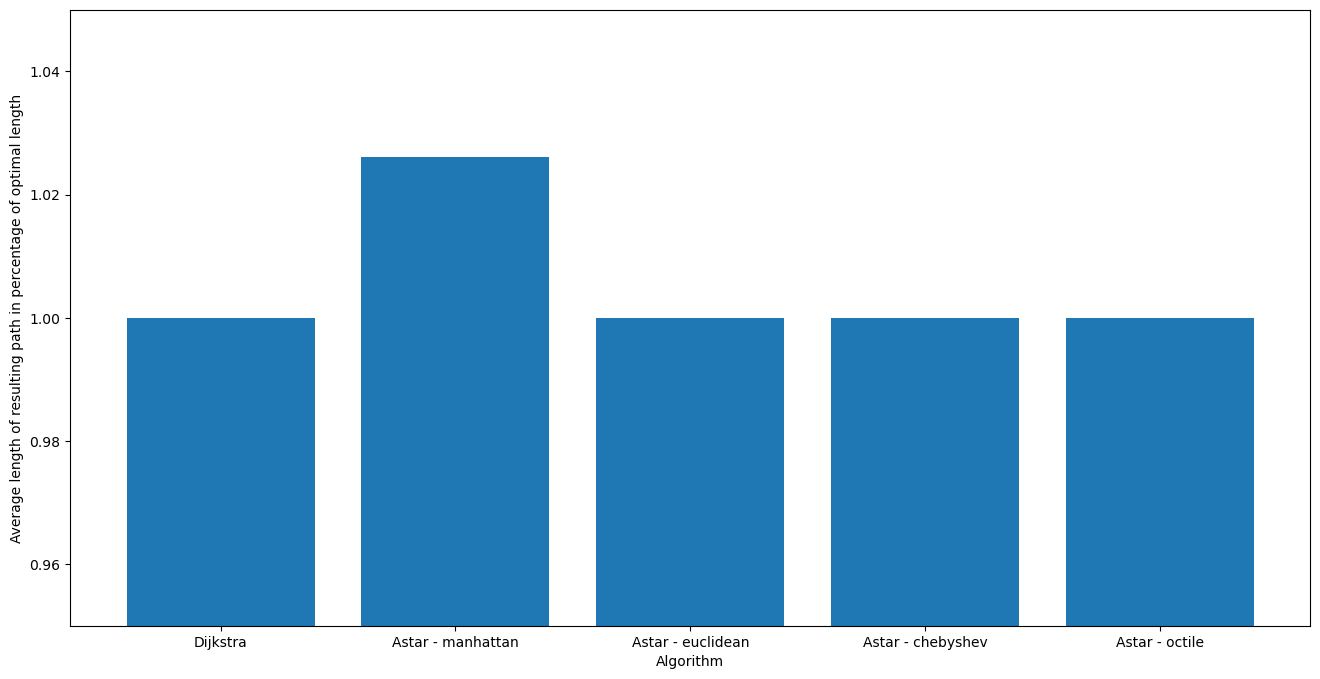

In [30]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlabel('Algorithm')
plt.ylabel('Average length of resulting path in percentage of optimal length')
ax.set_ylim(0.95, 1.05)
ax.bar(
    x=algorithm_names,
    height=[
        np.mean(np.hstack(np.array([length_percentage_of_optimal[alg][map_] for map_ in map_names])))
        for alg in algorithm_names
    ]
)
fig.show()
print(np.mean(np.hstack(np.array([length_percentage_of_optimal['Astar - manhattan'][map_] for map_ in map_names]))))

### Steps count

/var/folders/k5/l4kgrfbj54l69z4l6p2vxb8h0000gn/T/ipykernel_78775/3506798151.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


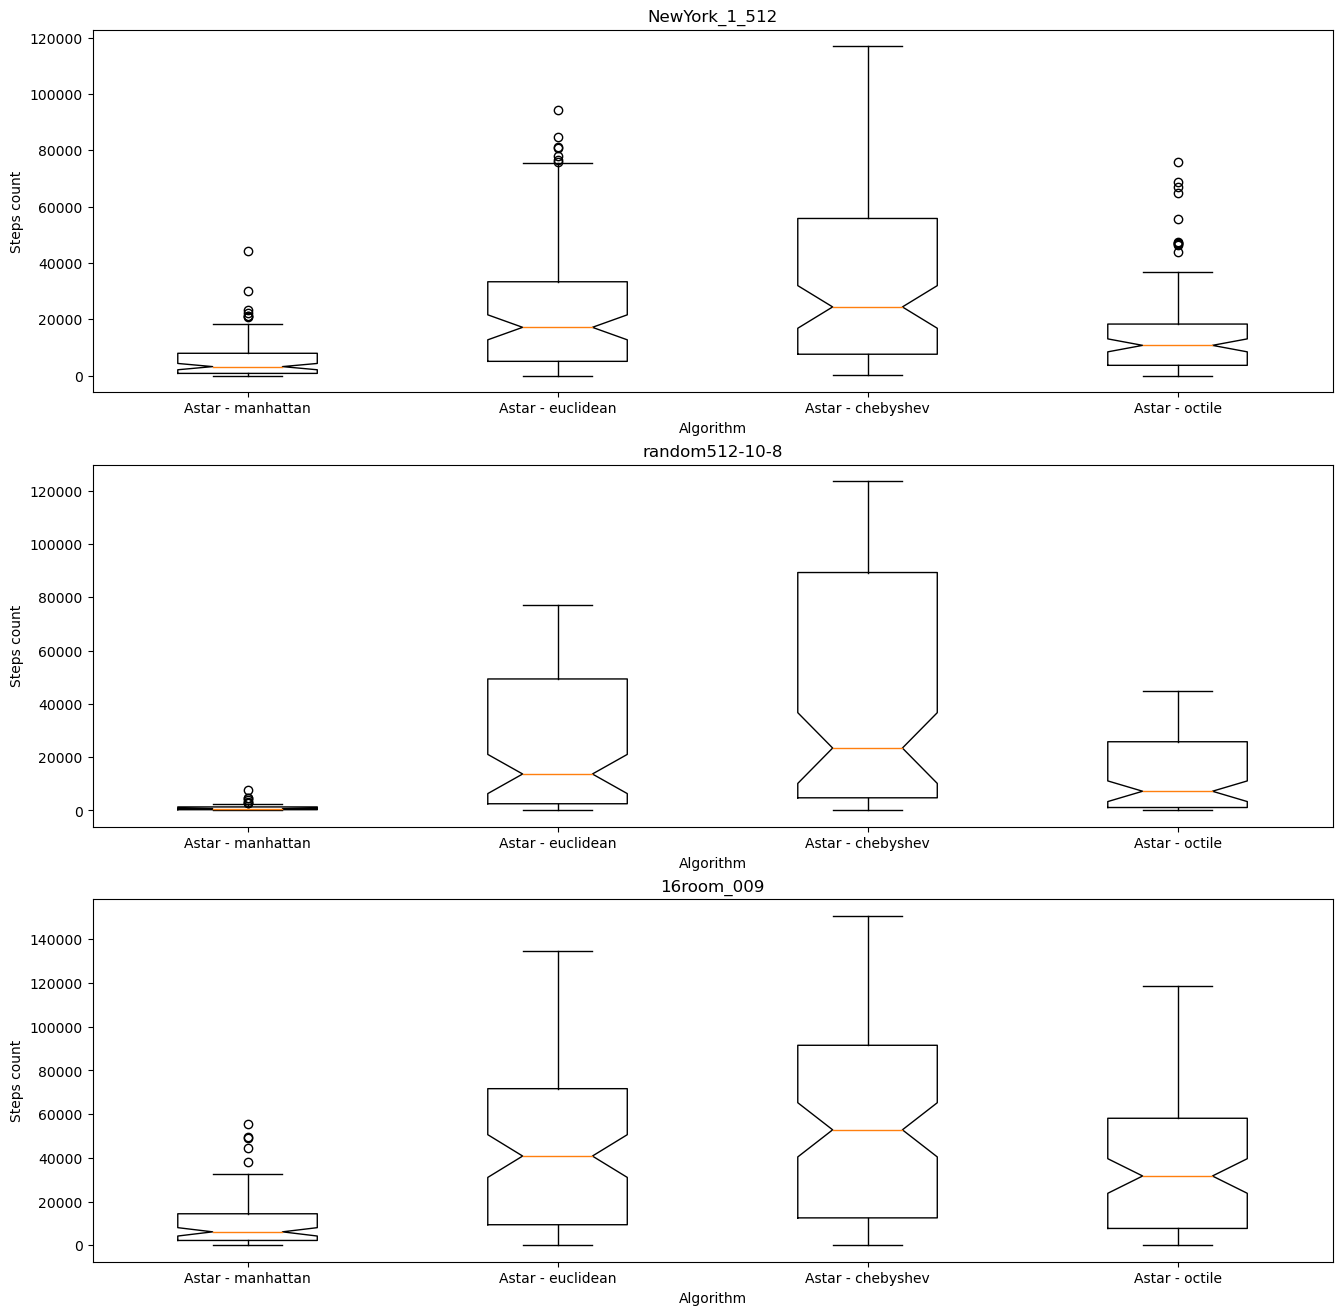

In [31]:
fig, axes = plt.subplots(3, figsize=(16, 16))

for i, map_ in enumerate(map_names):
    
    ax = axes[i]
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Steps count')
    ax.set_title(map_)

    ax.boxplot(
        [steps[alg][map_] for alg in astar_algorithm_names],
        labels=astar_algorithm_names,
        notch=True
    )
    
fig.show()

/var/folders/k5/l4kgrfbj54l69z4l6p2vxb8h0000gn/T/ipykernel_78775/573619452.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


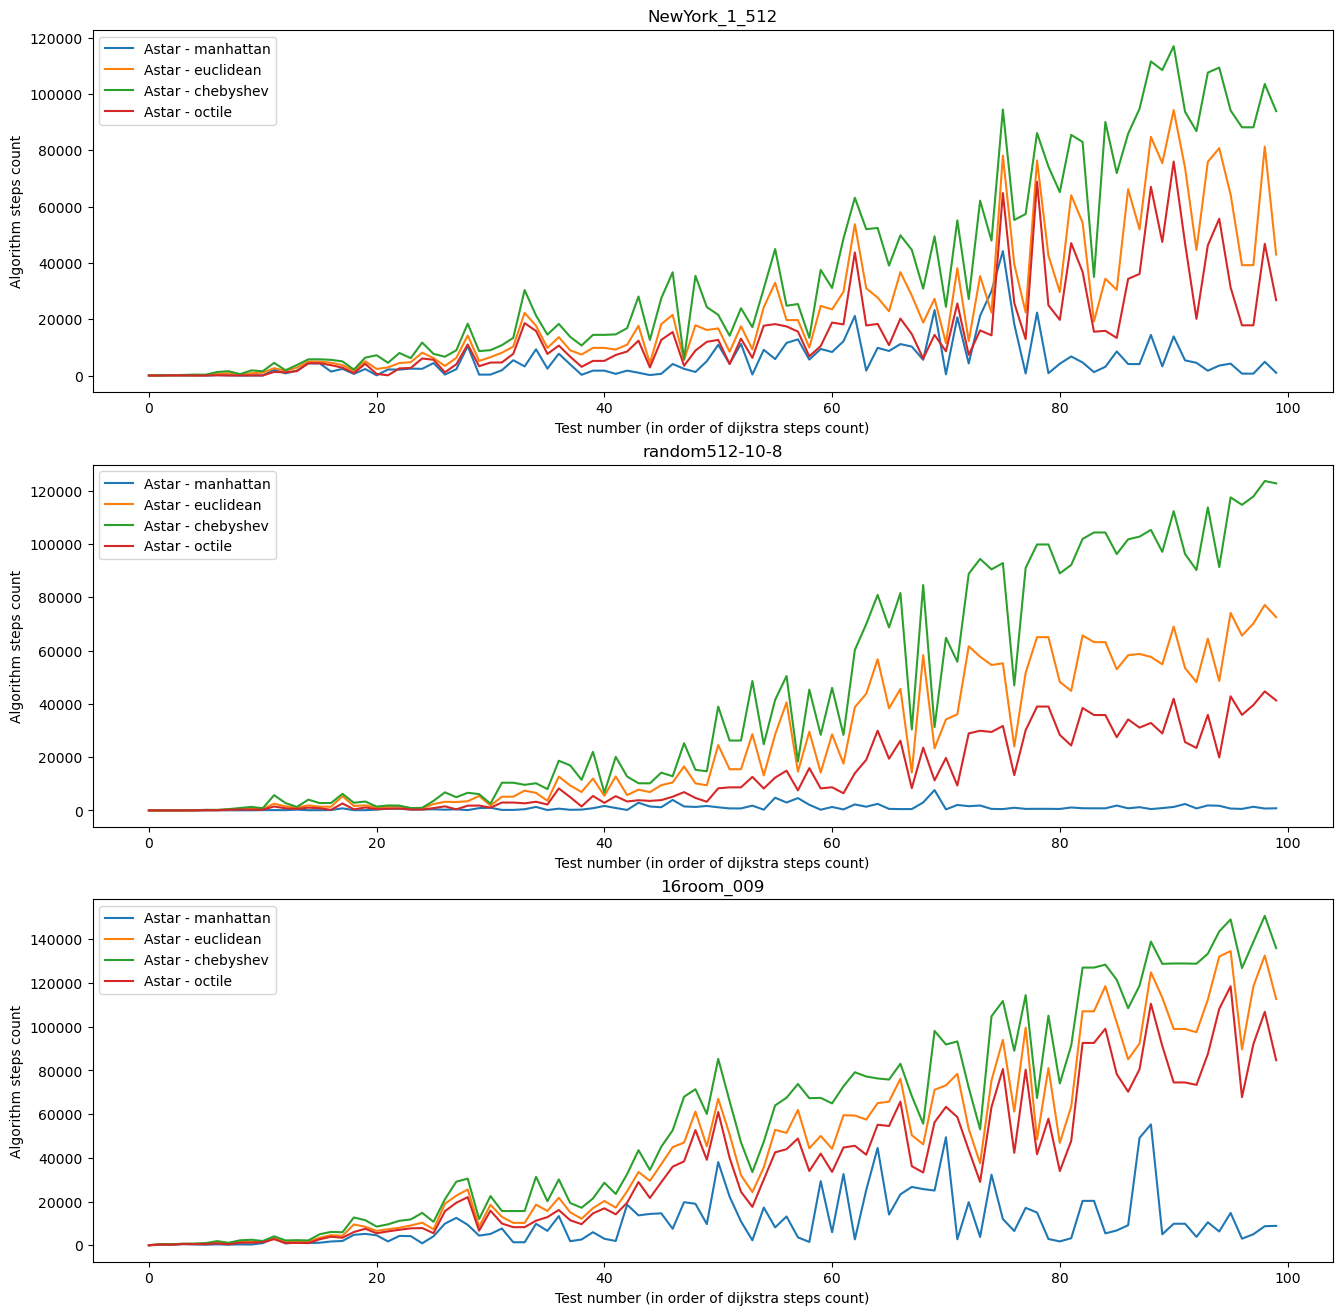

In [32]:
fig, axes = plt.subplots(3, figsize=(16, 16))

for i, map_ in enumerate(map_names):

    sort_index = np.argsort(steps['Dijkstra'][map_])

    ax = axes[i]    
    ax.set_xlabel('Test number (in order of dijkstra steps count)')
    ax.set_ylabel('Algorithm steps count')
    ax.set_title(map_)

    for alg in astar_algorithm_names:
        alg_steps = np.array(steps[alg][map_])[sort_index]
        ax.plot(range(100), alg_steps)
    ax.legend(astar_algorithm_names)

fig.show()

## Expansions count

Number of expansions for each map

/var/folders/k5/l4kgrfbj54l69z4l6p2vxb8h0000gn/T/ipykernel_78775/1863853130.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


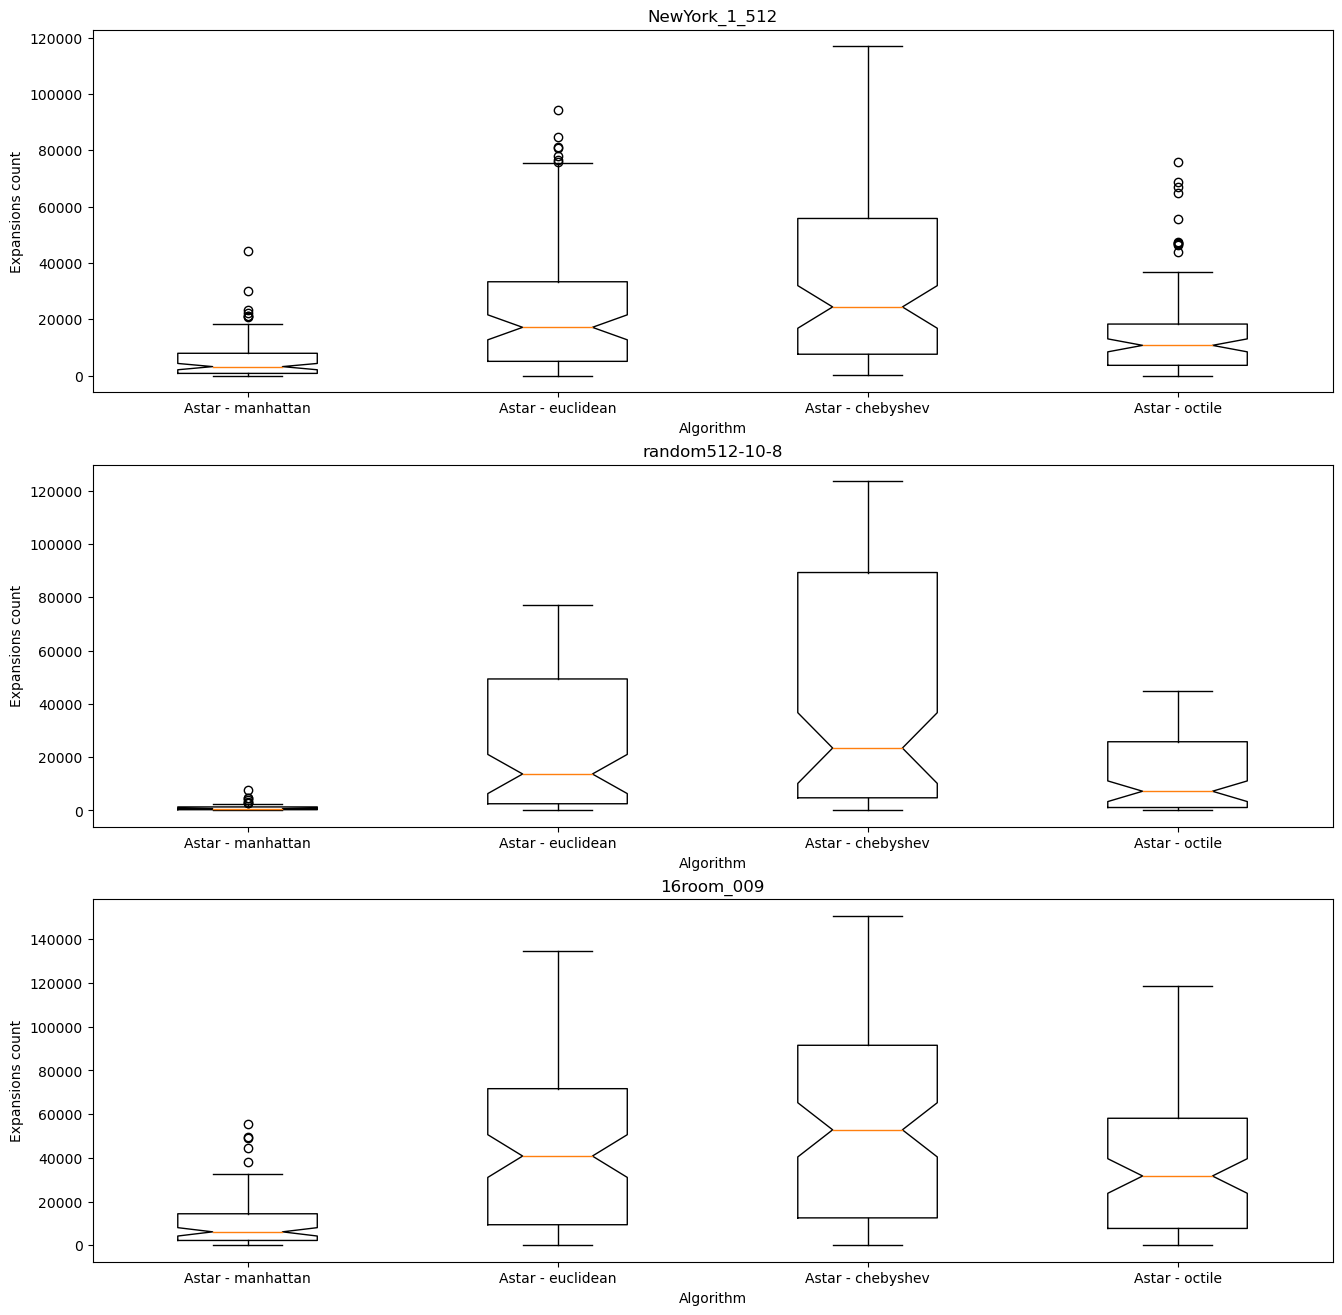

In [35]:
fig, axes = plt.subplots(3, figsize=(16, 16))

for i, map_ in enumerate(map_names):
    
    ax = axes[i]
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Expansions count')
    ax.set_title(map_)

    ax.boxplot(
        [expansions[alg][map_] for alg in astar_algorithm_names],
        labels=astar_algorithm_names,
        notch=True
    )
    
fig.show()

/var/folders/k5/l4kgrfbj54l69z4l6p2vxb8h0000gn/T/ipykernel_78775/3805091405.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


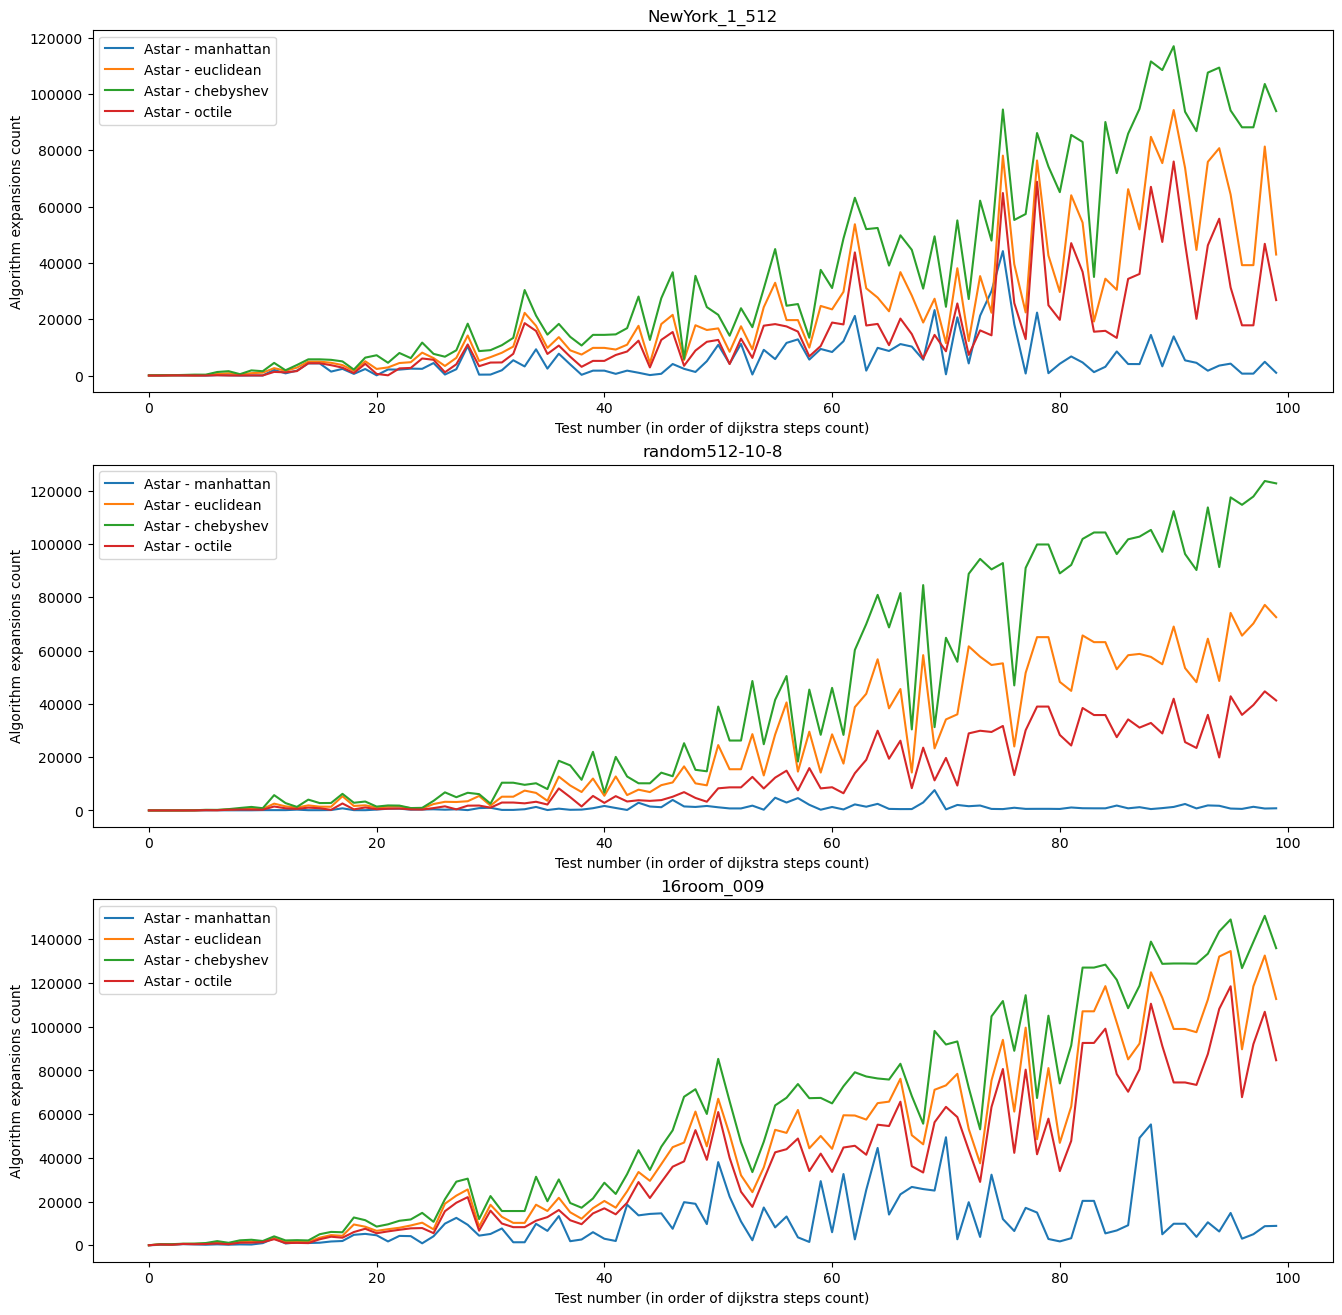

In [36]:
fig, axes = plt.subplots(3, figsize=(16, 16))

for i, map_ in enumerate(map_names):

    sort_index = np.argsort(expansions['Dijkstra'][map_])

    ax = axes[i]    
    ax.set_xlabel('Test number (in order of dijkstra steps count)')
    ax.set_ylabel('Algorithm expansions count')
    ax.set_title(map_)

    for alg in astar_algorithm_names:
        alg_steps = np.array(expansions[alg][map_])[sort_index]
        ax.plot(range(100), alg_steps)
    ax.legend(astar_algorithm_names)

fig.show()

## Conclusion

The Astar algorithm works as expected:

- manhattan version doesn't find the optimal path, though it works much faster than the other three
- all of the euclidean, chebyshev and octile versions always find the path with optimal length
- octile version is slightly better than the chebyshev one, and chebyshev is better than euclidean in both steps count and expansions count